In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")  # if simulator.ipynb is in /notebooks/

import pickle

from simulation.helpers import create_circular_roads
from simulation.core import System
from simulation.controller import TrafficController
from simulation.data_logger import DataLogger
from simulation.spawners import timed_spawner
from simulation.core import Road, Lane, Car


In [ ]:
dt = 0.005
sim_time = 50

system = System(dt=dt, final_time=sim_time)

start_pos = (100, 300)
end_pos = (700, 300)
roads = create_circular_roads(10, 1, 300, max_speed=200)

for road in roads:
    system.add_road(road)

logger = DataLogger(tag="basic_one_road_test")
controller = TrafficController(system, logger=logger)

controller.equal_distance_car_creator(20, lane_index=0)


In [131]:
# Run loop
for _ in range(int(system.final_time / system.dt)):
    controller.control(system.dt)
    system.update(logger=logger)


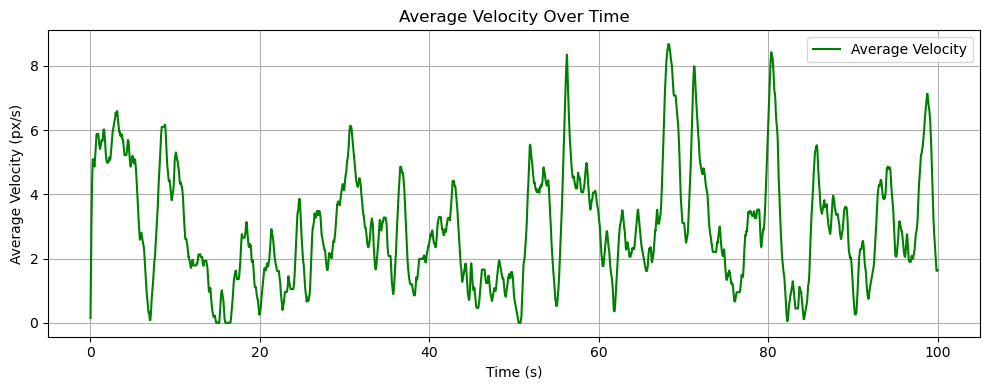

In [133]:
df = logger.to_dataframe()

# Group by time and calculate average velocity
avg_velocity_by_time = df.groupby("time")["velocity"].mean()

# Plot average velocity over time
plt.figure(figsize=(10, 4))
plt.plot(avg_velocity_by_time.index, avg_velocity_by_time.values, label="Average Velocity", color='green')
plt.xlabel("Time (s)")
plt.ylabel("Average Velocity (px/s)")
plt.title("Average Velocity Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

[4, 300.00000000000017]
[5, 300.00000000000017]
[6, 281.8000000000029]
[7, 128.22857142857342]
[8, 114.45000000000148]
[9, 104.90000000000111]
[10, 98.10000000000086]
[11, 92.72727272727339]
[12, 88.20000000000049]
[13, 84.02307692307726]
[14, 80.37857142857162]
[15, 76.94000000000005]
[16, 73.81874999999994]
[17, 71.04705882352926]
[18, 68.39999999999974]
[19, 65.99999999999964]
[20, 63.73499999999957]
[21, 61.599999999999596]
[22, 59.69999999999961]
[23, 57.83478260869528]
[24, 56.07499999999965]
[25, 54.29999999999966]
[26, 52.73076923076891]
[27, 51.29999999999969]
[28, 49.778571428571134]
[29, 48.29999999999972]
[30, 47.09999999999973]
[31, 45.599999999999746]
[32, 44.39999999999976]
[33, 43.218181818181584]
[34, 42.09705882352919]
[35, 40.92857142857122]
[36, 39.8999999999998]
[37, 38.87837837837819]
[38, 37.79999999999982]
[39, 36.738461538461365]
[40, 35.759999999999835]
[41, 34.79999999999985]
[42, 33.89999999999986]
[43, 32.999999999999865]
[44, 32.09999999999987]
[45, 31.199

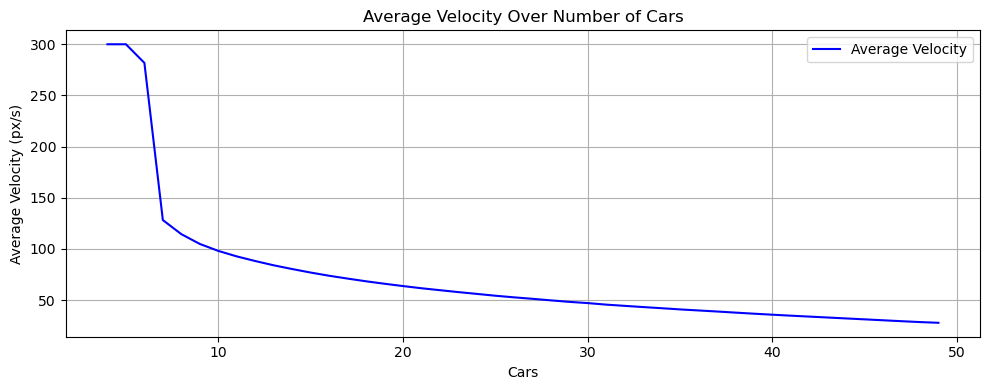

In [123]:
import matplotlib.pyplot as plt

avg_velocities = []
for num in range(4, 50):
    system = System(dt=dt, final_time=sim_time)
    roads = create_circular_roads(10, 1, 300, max_speed=10000)

    for road in roads:
        system.add_road(road)

    logger = DataLogger(tag="basic_one_road_test")
    controller = TrafficController(system, logger=logger)

    controller.equal_distance_car_creator(num)
    # Run loop
    for _ in range(int(system.final_time / system.dt)):
        controller.control(system.dt)
        system.update(logger=logger)

    # Get the full log data
    df = logger.to_dataframe()

    # Group by time and compute average velocity
    avg_velocity_by_time = df.groupby("time")["velocity"].mean()
    avg_velocities.append([num, avg_velocity_by_time[sim_time-1]])
    print(avg_velocities[-1])

# Plot
avg_velocities = np.array(avg_velocities)
x = avg_velocities[:, 0]  # car numbers
y = avg_velocities[:, 1]  # average velocities

plt.figure(figsize=(10, 4))
plt.plot(x, y, label="Average Velocity", color='blue')
plt.xlabel("Cars")
plt.ylabel("Average Velocity (px/s)")
plt.title("Average Velocity Over Number of Cars")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
